In [1]:
import sys
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

# jax config
from jax import config
config.update("jax_enable_x64", True)

## Define cost function

In [2]:
from opentn.optimization import frobenius_norm, model_stiefel_local
from opentn.transformations import create_trotter_layers, create_kitaev_liouvillians

d = 2
tau = 1
gamma = 1

f_stiefel = lambda xi, exact, N: frobenius_norm(model_stiefel_local(xi, N, d, ), exact)

# Kitaev model checking for higher sites

## Load optimized data

In [3]:
xs_kitaev_n1 = np.load("xs_kitaev_n1_tau_1_r2.npy")
xs_kitaev_n2 = np.load("xs_kitaev_n2_tau_1_r2.npy")
xs_kitaev_n3 = np.load("xs_kitaev_n3_tau_1_r2.npy")
xs_kitaev_n4 = np.load("xs_kitaev_n4_tau_1_r2.npy")
xs_kitaev_n5 = np.load("xs_kitaev_n5_tau_1_r2.npy")

xs_ns = [xs_kitaev_n1, xs_kitaev_n2, xs_kitaev_n3, xs_kitaev_n4, xs_kitaev_n5]


## Data for N4 

In [4]:
N = 4
Lvec_N4, Lvec_odd_N4, Lvec_even_N4, Lnn_N4 = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec_N4, *_ = create_trotter_layers([Lvec_N4], tau=tau)

In [5]:
f_stiefel_N4 = []
for xs in xs_ns:
    f_value = f_stiefel(xs, exp_Lvec_N4, 4)
    print(f_value)
    f_stiefel_N4.append(f_value)

0.00496715711391047
0.0006768010248246861
0.0002717539944560329
0.0001472948282697468
9.223435089048957e-05


## Data for N6

In [6]:
Lvec_N6, Lvec_odd_N6, Lvec_even_N6, Lnn_N6 = create_kitaev_liouvillians(N=6, d=d, gamma=gamma, pbc=True)

In [7]:
exp_Lvec_N6, exp_Lvec_odd_N6, exp_Lvec_even_N6 = create_trotter_layers([Lvec_N6, Lvec_odd_N6, Lvec_even_N6], tau=tau)

In [8]:
from opentn.transformations import compose_superops_list
superop_n1_trotter = compose_superops_list([exp_Lvec_odd_N6,exp_Lvec_even_N6,exp_Lvec_odd_N6])

In [9]:
frobenius_norm(exp_Lvec_N6, superop_n1_trotter)

Array(0.02576505, dtype=float64)

In [10]:
f_stiefel_N6 = []
for xs in xs_ns:
    f_value = f_stiefel(xs, exp_Lvec_N6, 6)
    print(f_value)
    f_stiefel_N6.append(f_value)

0.020389224515887507
0.0024189940501043367
0.0009578463626492272
0.0005240788104448452
0.00032922358055327057


In [11]:
# how do these compare agains the non optimized Trotter splitting?
from opentn.transformations import super2ortho
from opentn.optimization import get_general_trotter_local_ansatz

f_trotter_ts = []
for n in range(1, 6):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Lnn_N6, tau=tau, n=n)]
    f_value = f_stiefel(xs_trotter_ts, exp_Lvec_N6, 6)
    print(f_value)
    f_trotter_ts.append(f_value)

0.02576504713817758
0.006454398595345879
0.0028697059817407652
0.0016144232347802502
0.0010332941654906656


In [12]:
f_trotter_ts_N4 = []
for n in range(1, 6):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Lnn_N4, tau=tau, n=n)]
    f_value = f_stiefel(xs_trotter_ts, exp_Lvec_N4, 4)
    print(f_value)
    f_trotter_ts_N4.append(f_value)

0.005992052805369223
0.001500322841440693
0.0006670002231766371
0.00037522504487497914
0.00024015511328987033


## Data for 8 sites

In [4]:
from opentn.transformations import create_kitaev_liouvillians
Lvec_N8, Lvec_odd_N8, Lvec_even_N8, Lnn_N8 = create_kitaev_liouvillians(N=8, d=d, gamma=gamma, pbc=True)

: 

: 

## Plotting

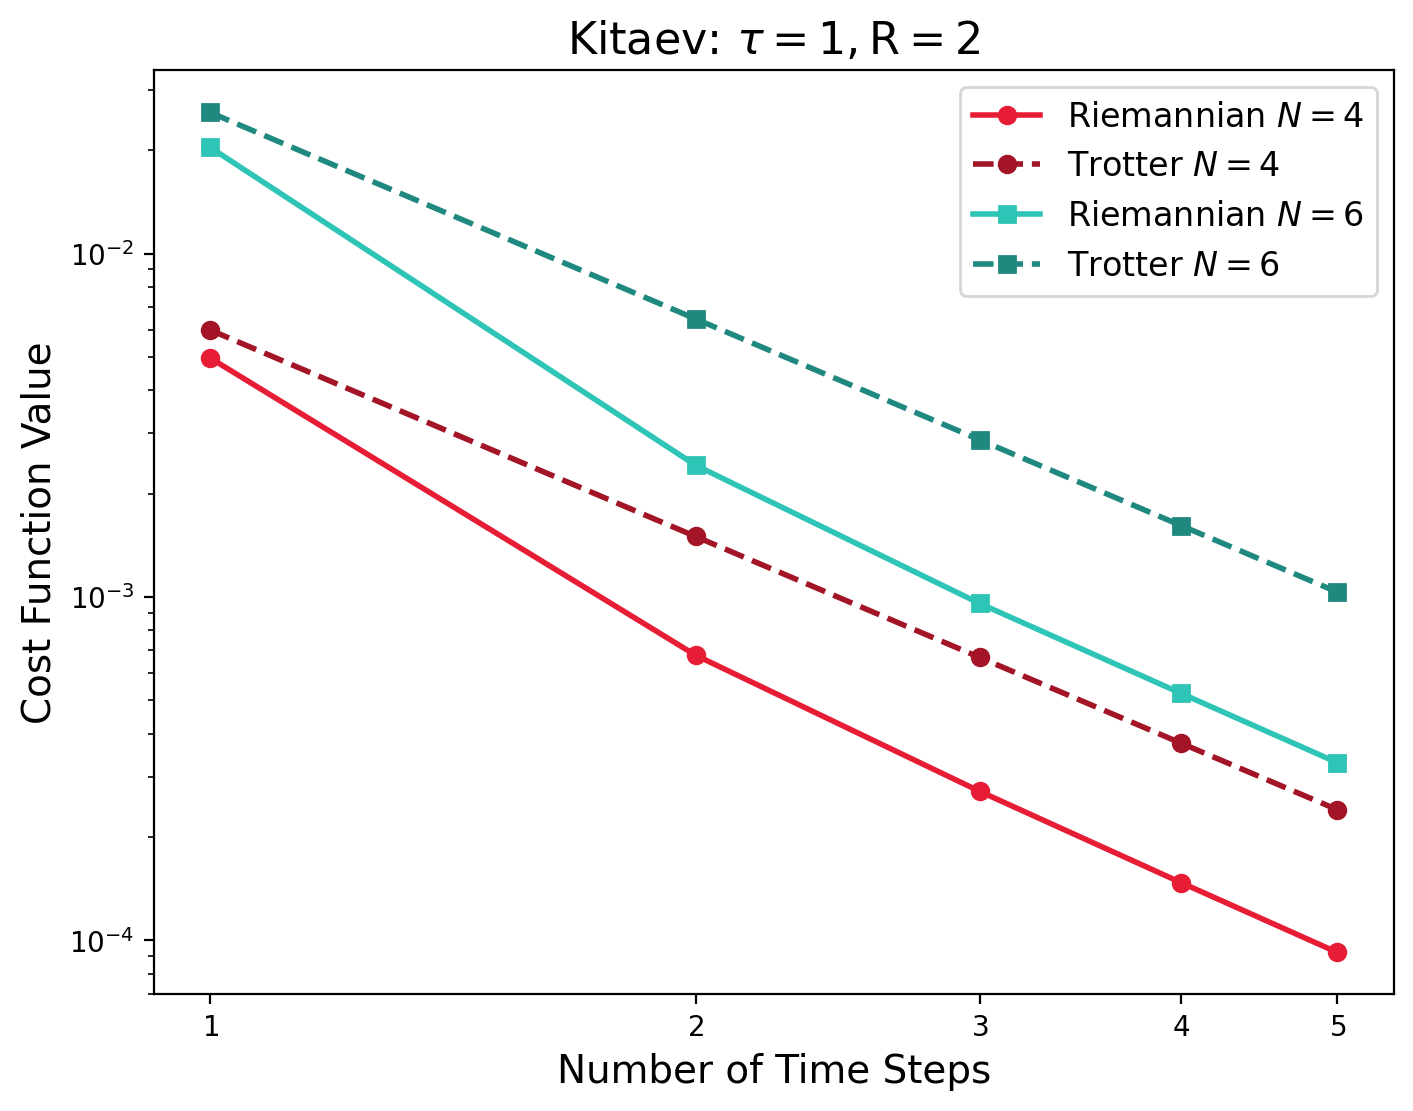

In [19]:
from opentn.utils import plot_pretty, plot_groups_pretty

labels = [[r"Riemannian $N=4$", r"Trotter $N=4$"], [r"Riemannian $N=6$", r"Trotter $N=6$"]]
error_data = [[f_stiefel_N4, f_trotter_ts_N4], [f_stiefel_N6, f_trotter_ts]]
title = r"Kitaev: $\tau = 1, \mathrm{R}=2$"

fig_N4_N6 = plot_groups_pretty(
    ygroups=error_data,
    labels=labels,
    ylabel="Cost Function Value",
    title=title,
    xlabel="Number of Time Steps",
    legend_out=False,
    loglog=True,
    integers=True,
    shade_step=0.3
)
fig_N4_N6.savefig('../images/thesis/cost_kitaev_higher_sites.pdf', bbox_inches='tight')


In [20]:
# Let's compare the ratios
ratio_N4 = []
for f1, f2 in zip(f_stiefel_N4, f_trotter_ts_N4):
    ratio_N4.append(f1/f2)

ratio_N6 = []
for f1, f2 in zip(f_stiefel_N6, f_trotter_ts):
    ratio_N6.append(f1/f2)

ratios = [ratio_N4, ratio_N6]

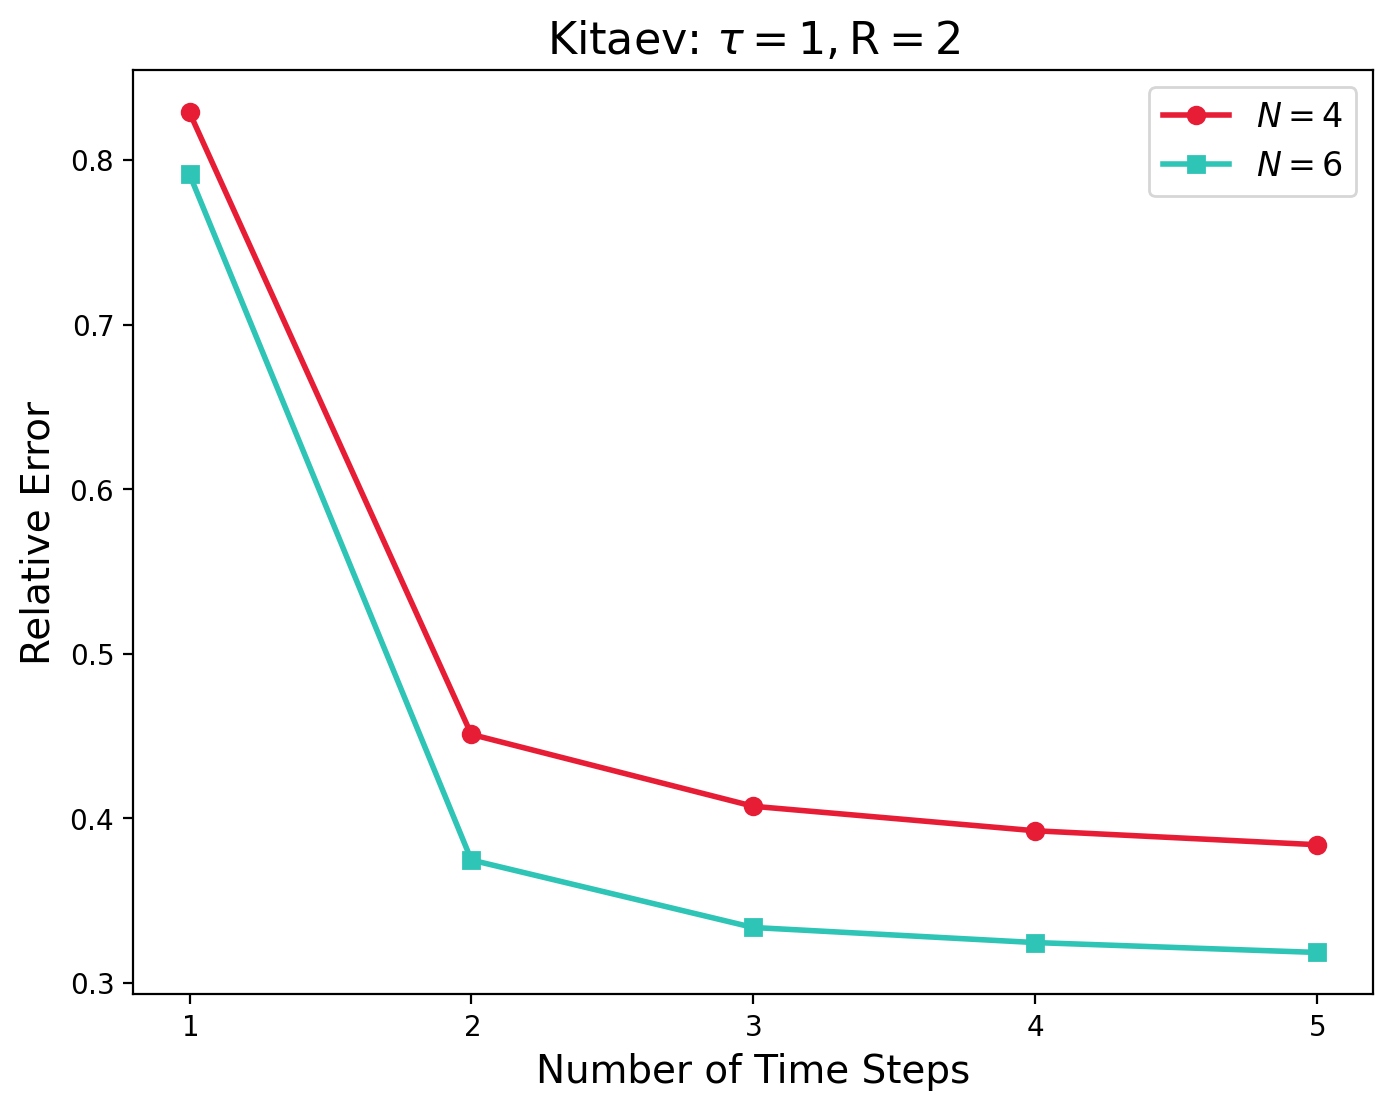

In [21]:
labels = [r"$N=4$", r"$N=6$"]
title = r"Kitaev: $\tau = 1, \mathrm{R}=2$"

fig_ratios = plot_pretty(
    ydatas=ratios,
    labels=labels,
    ylabel="Relative Error",
    title=title,
    xlabel="Number of Time Steps",
    legend_out=False,
    use_semilogy=False,
    idx_main=1,
    integers=True,
    colour_palette=['#E71D36', '#2EC4B6']
)

# fig_ratios.savefig('../images/thesis/error_relative_kitaev_higher_sites.pdf', bbox_inches='tight')



## Tests

In [28]:
from opentn.transformations import permute_cyclic
permute_cyclic(list(range(6)), direction='right'), permute_cyclic(list(range(6)), 1)

([5, 0, 1, 2, 3, 4], [1, 2, 3, 4, 5, 0])

In [29]:
permute_cyclic(list(range(4)), direction='right'), permute_cyclic(list(range(4)), 1)

([3, 0, 1, 2], [1, 2, 3, 0])

In [27]:
from opentn.transformations import get_indices_supertensored2liouvillianfull
source_indices, destination_indices = get_indices_supertensored2liouvillianfull(6)
source_indices, destination_indices


([2, 3, 6, 7, 14, 15, 18, 19], [6, 7, 8, 9, 18, 19, 20, 21])

# PSPL model

## Load optimized data

In [13]:
xs_pspl_n1 = np.load("xs_timestep_1_opt_4.npy")
xs_pspl_n2 = np.load("xs_pspl_timestep_2_opt_4.npy")
xs_pspl_n3 = np.load("xs_pspl_timestep_3_opt_6.npy")
xs_pspl_n4 = np.load("xs_timestep_4_opt_9.npy")

xs_pspl_ns = [xs_pspl_n1, xs_pspl_n2, xs_pspl_n3, xs_pspl_n4]


## Data for N4

In [14]:
from opentn.states.qubits import X, Z, I
from opentn.transformations import create_2local_liouvillians

L0 = np.sqrt(gamma)*(np.kron(X, I) - np.kron(I, X))
L1 = np.sqrt(gamma)*(np.kron(Z, I) - np.kron(I, Z))
Li = [L0, L1]

Lvec_full_pspl_N4, Lvec_odd_pspl_N4, Lvec_even_pspl_N4 = create_2local_liouvillians(Li=Li, N=4, d=d, pbc=True)  
exp_Lvec_pspl_N4, exp_Lvec_odd_pspl_N4, exp_Lvec_even_pspl_N4 = create_trotter_layers([Lvec_full_pspl_N4, Lvec_odd_pspl_N4, Lvec_even_pspl_N4], tau=tau)

In [15]:
f_stiefel_pspl_N4 = []
for xs in xs_pspl_ns:
    f_value = f_stiefel(xs, exp_Lvec_pspl_N4, N=4)
    print(f_value)
    f_stiefel_pspl_N4.append(f_value)

0.004330344959560802
0.0007700307094206307
0.00023033004221166136
0.00013084858319670263


In [16]:
f_trotter_ts_pspl_N4 = []
for n in range(1, 5):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=n)]
    f_value = f_stiefel(xs_trotter_ts, exp_Lvec_pspl_N4, N=4)
    print(f_value)
    f_trotter_ts_pspl_N4.append(f_value)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

## Data for N6

In [ ]:
Lvec_full_pspl_N6, Lvec_odd_pspl_N6, Lvec_even_pspl_N6 = create_2local_liouvillians(Li=Li, N=6, d=d, pbc=True)  
exp_Lvec_pspl_N6, exp_Lvec_odd_pspl_N6, exp_Lvec_even_pspl_N6 = create_trotter_layers([Lvec_full_pspl_N6, Lvec_odd_pspl_N6, Lvec_even_pspl_N6], tau=tau)

In [ ]:
superop_n1_trotter_pspl = compose_superops_list([exp_Lvec_odd_pspl_N6,exp_Lvec_even_pspl_N6,exp_Lvec_odd_pspl_N6])
frobenius_norm(superop_n1_trotter_pspl, exp_Lvec_pspl_N6)

Array(0.0241597, dtype=float64)

In [ ]:
f_stiefel_pspl_N6 = []
for xs in xs_pspl_ns:
    f_value = f_stiefel(xs, exp_Lvec_pspl_N6, N=6)
    print(f_value)
    f_stiefel_pspl_N6.append(f_value)

0.003721011396699132
0.0006956930114157197
0.00024536148519329156
0.00014417292154202203


In [ ]:
f_trotter_ts_pspl_N6 = []
for n in range(1, 5):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=n)]
    f_value = f_stiefel(xs_trotter_ts, exp_Lvec_pspl_N6, N=6)
    print(f_value)
    f_trotter_ts_pspl_N6.append(f_value)

0.024159697951529304
0.00915214415433201
0.005072926683317593
0.0031446654472255


## Plotting

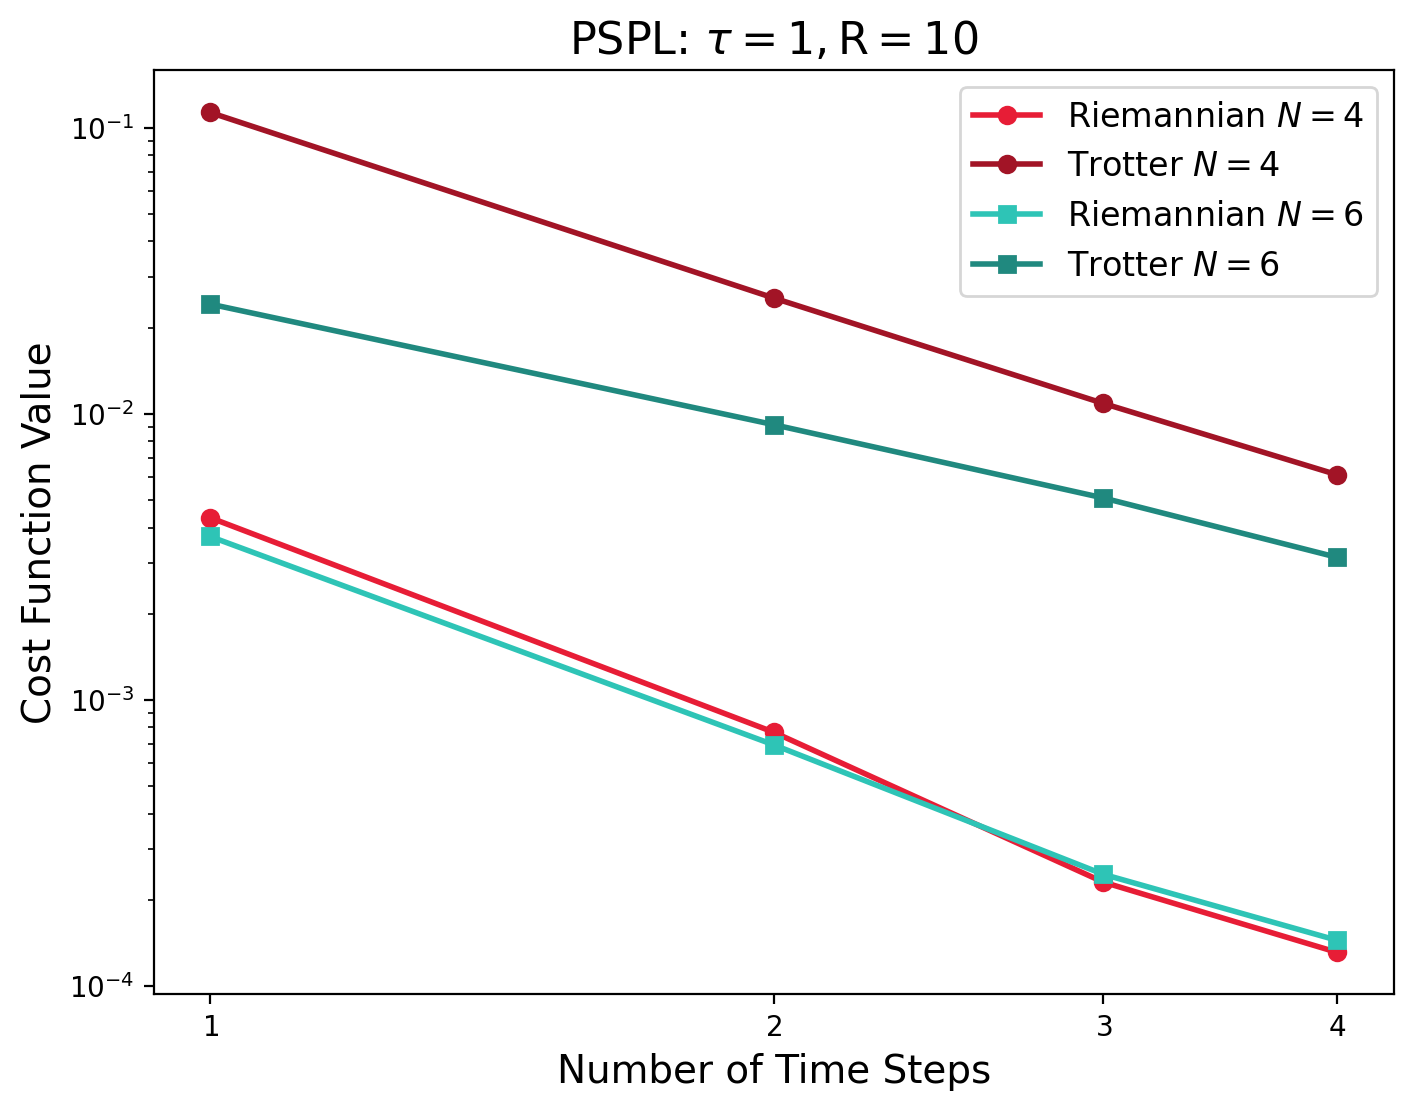

In [136]:
labels = [[r"Riemannian $N=4$",r"Trotter $N=4$"], [r"Riemannian $N=6$" , r"Trotter $N=6$"]]
error_data = [[f_stiefel_pspl_N4,f_trotter_ts_pspl_N4], [f_stiefel_pspl_N6, f_trotter_ts_pspl_N6]]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"

fig_N4_N6_pspl = plot_groups_pretty(
    ygroups=error_data,
    labels=labels,
    ylabel="Cost Function Value",
    title=title,
    xlabel="Number of Time Steps",
    legend_out=False,
    loglog=True,
    integers=True,
    shade_step=0.3
)

# fig_N4_N6_pspl.savefig('../images/thesis/cost_pspl_higher_sites.pdf', bbox_inches='tight')


In [71]:
# Let's compare the ratios
ratio_pspl_N4 = []
for f1, f2 in zip(f_stiefel_pspl_N4, f_trotter_ts_pspl_N4):
    ratio_pspl_N4.append(f1/f2)

ratio_pspl_N6 = []
for f1, f2 in zip(f_stiefel_pspl_N6, f_trotter_ts_pspl_N6):
    ratio_pspl_N6.append(f1/f2)

ratios_pspl = [ratio_pspl_N4, ratio_pspl_N6]

In [134]:
ratio_pspl_N4, ratio_pspl_N6

([Array(0.03834024, dtype=float64),
  Array(0.03035873, dtype=float64),
  Array(0.02121482, dtype=float64),
  Array(0.02140928, dtype=float64)],
 [Array(0.1540173, dtype=float64),
  Array(0.07601421, dtype=float64),
  Array(0.04836685, dtype=float64),
  Array(0.04584682, dtype=float64)])

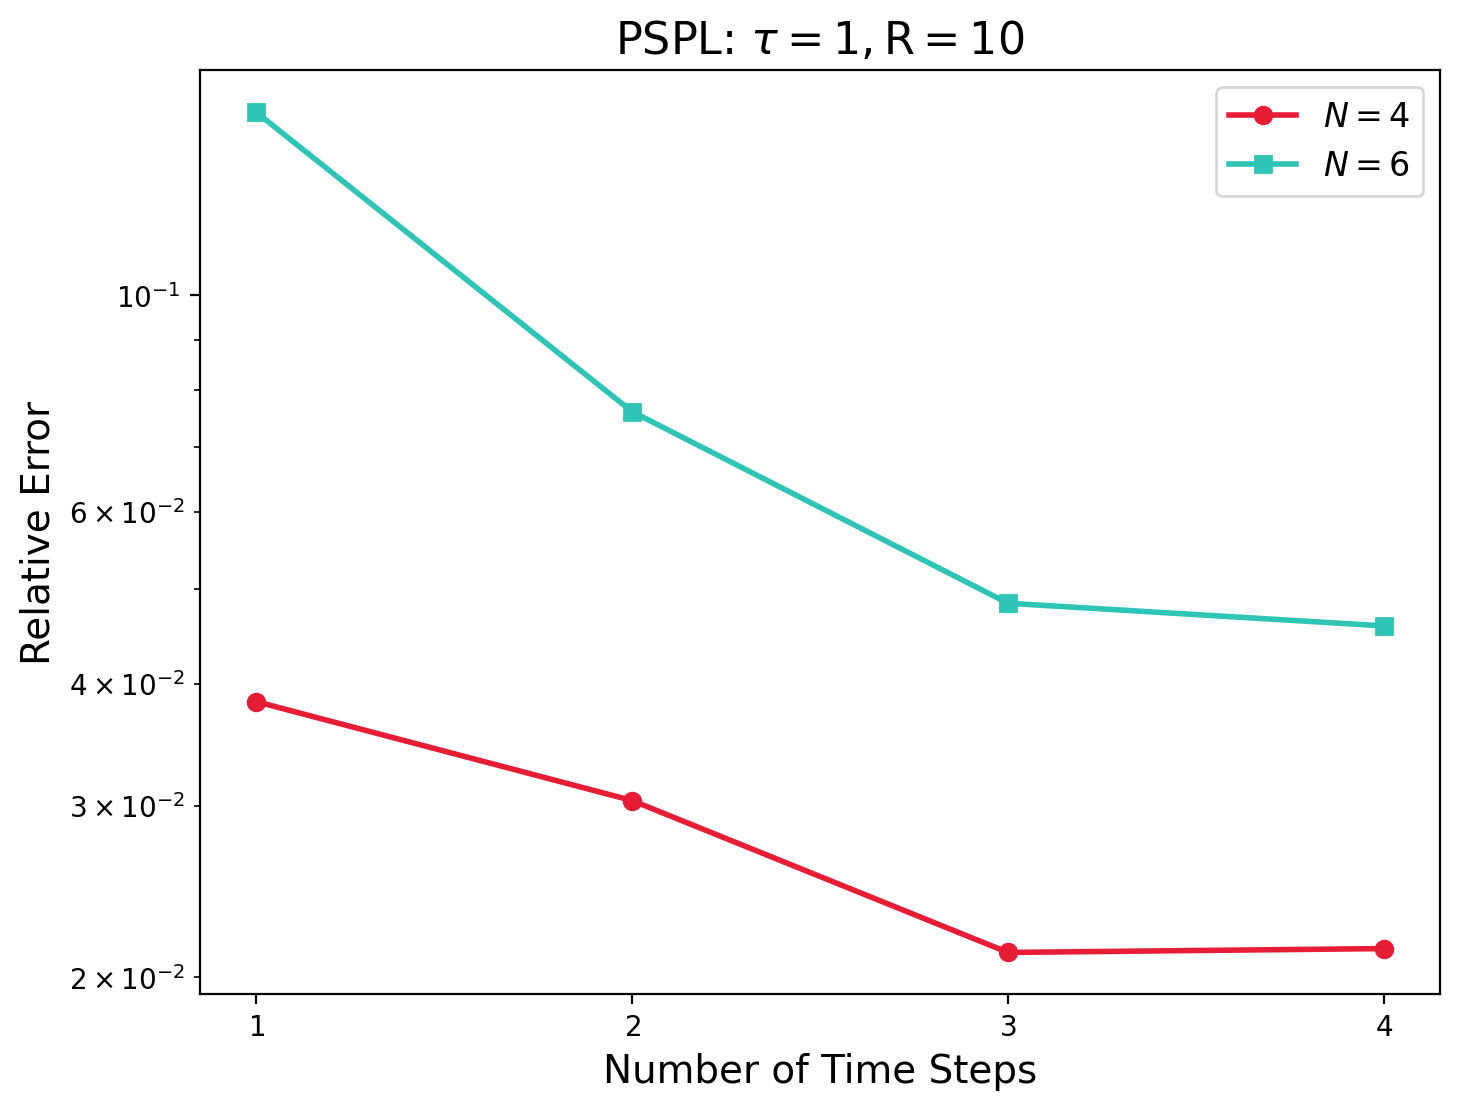

In [139]:
labels = [r"$N=4$", r"$N=6$"]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"

fig_ratios_pspl = plot_pretty(
    ydatas=ratios_pspl,
    labels=labels,
    ylabel="Relative Error",
    title=title,
    xlabel="Number of Time Steps",
    legend_out=False,
    use_semilogy=True,
    idx_main=1,
    integers=True,
    colour_palette=['#E71D36', '#2EC4B6'],
)
fig_ratios_pspl.savefig('../images/thesis/error_relative_pspl_higher_sites.pdf', bbox_inches='tight')
